Dataset shape: (3024, 13)
Columns: ['UserID', 'Age', 'Gender', 'Country', 'Device', 'GameGenre', 'SessionCount', 'AverageSessionLength', 'SpendingSegment', 'InAppPurchaseAmount', 'FirstPurchaseDaysAfterInstall', 'PaymentMethod', 'LastPurchaseDate']

Data types:
 UserID                            object
Age                              float64
Gender                            object
Country                           object
Device                            object
GameGenre                         object
SessionCount                       int64
AverageSessionLength             float64
SpendingSegment                   object
InAppPurchaseAmount              float64
FirstPurchaseDaysAfterInstall    float64
PaymentMethod                     object
LastPurchaseDate                  object
dtype: object

Missing values:
 UserID                             0
Age                               60
Gender                            60
Country                           60
Device                  

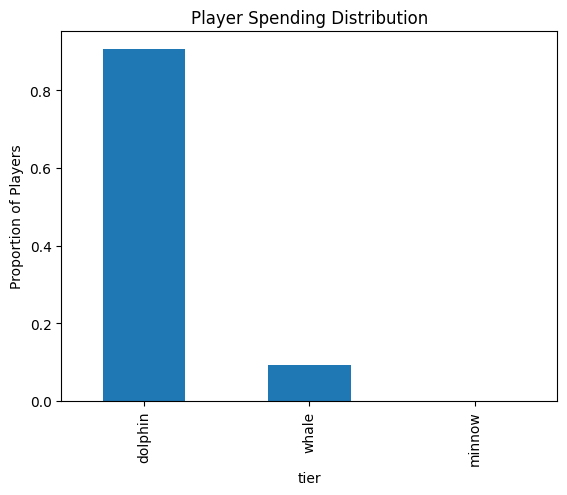

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind

# =========================
# Step 1. Load & Inspect
# =========================
# Load the dataset
df = pd.read_csv("mobile_game_inapp_purchases.csv")

# Quick overview
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())
print("\nSample rows:\n", df.head())


# =========================
# Step 2. Revenue Segmentation (Whales vs Minnows)
# =========================
# Check all column data types
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
spend_col = None

if numeric_cols:
    spend_col = numeric_cols[0]   # pick the first numeric column
    print(f"\nUsing numeric spending column: {spend_col}")

    # Segment into Minnow / Dolphin / Whale
    df["tier"] = pd.cut(df[spend_col],
                        bins=[-0.01, 5, 50, float("inf")],
                        labels=["minnow", "dolphin", "whale"])
    tier_counts = df["tier"].value_counts(normalize=True)

else:
    # Fallback: use categorical SpendingSegment if numeric not found
    spend_col = "SpendingSegment"
    print(f"\nUsing categorical segmentation column: {spend_col}")
    df["tier"] = df[spend_col]
    tier_counts = df["tier"].value_counts(normalize=True)

print("\nTier distribution:\n", tier_counts)

# Visualization
tier_counts.plot(kind="bar", title="Player Spending Distribution")
plt.ylabel("Proportion of Players")
plt.show()



Tier distribution table:
          players     share   avg_spend
tier                                   
nonpayer      137  0.045304    0.000000
minnow        605  0.200066    2.461223
dolphin      1859  0.614749   12.893330
whale         423  0.139881  640.192837

Cross-check with provided SpendingSegment (row counts):
SpendingSegment  Dolphin  Minnow  Whale
tier                                   
nonpayer              20     112      5
minnow                 0     605      0
dolphin               32    1827      0
whale                360       0     63


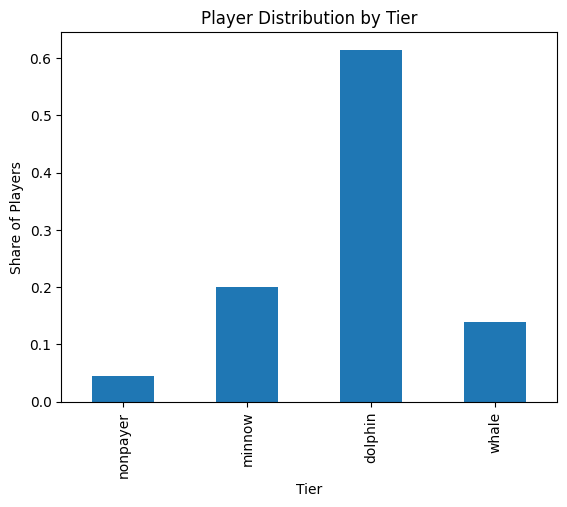

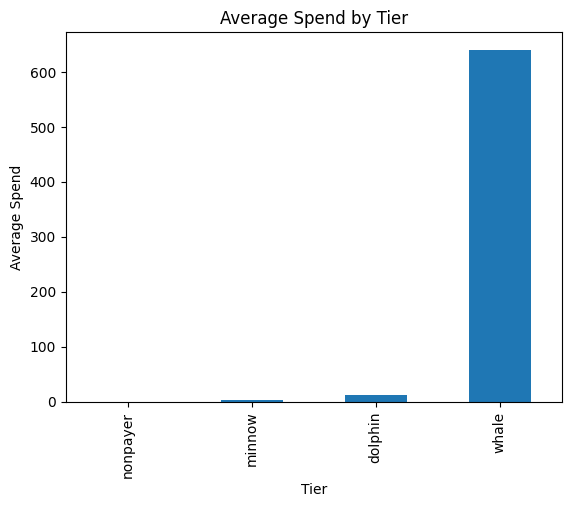

In [11]:
# =========================
# STEP 2 — Player Segmentation (clean + robust)
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 2.1 Choose the numeric spending column explicitly (from your dtypes)
spend_col = "InAppPurchaseAmount"
assert spend_col in df.columns, f"Column '{spend_col}' not found."

# 2.2 Create a cleaned spend feature for segmentation
# - Coerce to numeric
# - Clip negatives to 0 (defensive)
# - Fill NaNs to 0 so non-payers are handled consistently
df["spend_raw"] = df[spend_col]
df["spend"] = (
    pd.to_numeric(df[spend_col], errors="coerce")
      .clip(lower=0)
      .fillna(0.0)
)

# 2.3 Payer flag
df["is_payer"] = df["spend"] > 0

# 2.4 Define tiers
# Industry-friendly thresholds (tune as needed):
#   0 = nonpayer
#   (0, 5] = minnow
#   (5, 50] = dolphin
#   (50, +inf) = whale
bins = [0, 5, 50, np.inf]
labels = ["minnow", "dolphin", "whale"]

# Use a two-step approach to keep 0 as a dedicated "nonpayer" bucket
tier_positive = pd.cut(
    df.loc[df["spend"] > 0, "spend"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
)

df["tier"] = "nonpayer"
df.loc[df["spend"] > 0, "tier"] = tier_positive.astype(str)

# Make 'tier' an ordered categorical for nicer summaries
cat_type = pd.api.types.CategoricalDtype(
    categories=["nonpayer", "minnow", "dolphin", "whale"],
    ordered=True
)
df["tier"] = df["tier"].astype(cat_type)

# 2.5 Distribution table: counts, share, avg spend per tier
tier_dist = (
    df["tier"]
      .value_counts(dropna=False)
      .rename_axis("tier")
      .to_frame("players")
      .sort_index()
)
tier_dist["share"] = tier_dist["players"] / len(df)
tier_dist["avg_spend"] = df.groupby("tier", observed=True)["spend"].mean()
print("\nTier distribution table:")
print(tier_dist)

# 2.6 Optional: cross-check against provided categorical labels (if present)
if "SpendingSegment" in df.columns:
    print("\nCross-check with provided SpendingSegment (row counts):")
    print(pd.crosstab(df["tier"], df["SpendingSegment"], dropna=False))

# 2.7 Plot player share by tier
tier_dist["share"].plot(kind="bar", title="Player Distribution by Tier")
plt.ylabel("Share of Players")
plt.xlabel("Tier")
plt.show()

# 2.8 (Optional) Plot average spend by tier (helps sanity-check binning)
tier_dist["avg_spend"].plot(kind="bar", title="Average Spend by Tier")
plt.ylabel("Average Spend")
plt.xlabel("Tier")
plt.show()


In [12]:
# =========================
# Step 3. KPI Monitoring
# =========================
# Define key player counts
total_players = df["user_id"].nunique() if "user_id" in df.columns else df.shape[0]
paying_players = df[df[spend_col] > 0].shape[0]
total_revenue = df[spend_col].sum()

# Calculate KPIs
arpu = total_revenue / total_players
arppu = total_revenue / paying_players if paying_players > 0 else 0
penetration = paying_players / total_players

# Print KPI results
print("\nKPI Metrics:")
print(f"Total Players: {total_players}")
print(f"Paying Players: {paying_players}")
print(f"Total Revenue: {total_revenue:.2f}")
print(f"ARPU: {arpu:.2f}")
print(f"ARPPU: {arppu:.2f}")
print(f"Penetration Rate: {penetration:.2%}")




KPI Metrics:
Total Players: 3024
Paying Players: 2887
Total Revenue: 296259.31
ARPU: 97.97
ARPPU: 102.62
Penetration Rate: 95.47%


/tmp/ipython-input-1068655561.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  revenue_by_tier = df.groupby("tier")["spend"].sum().sort_values(ascending=False)



Revenue contribution by tier:
tier
whale       270801.57
dolphin      23968.70
minnow        1489.04
nonpayer         0.00
Name: spend, dtype: float64

Revenue share by tier:
tier
whale       0.914069
dolphin     0.080904
minnow      0.005026
nonpayer    0.000000
Name: spend, dtype: float64


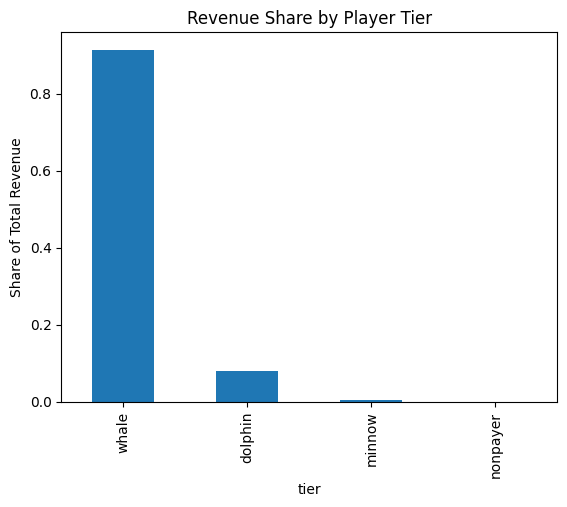


Top 5% players contribute: 72.21% of total revenue
Top 10% players contribute: 86.47% of total revenue


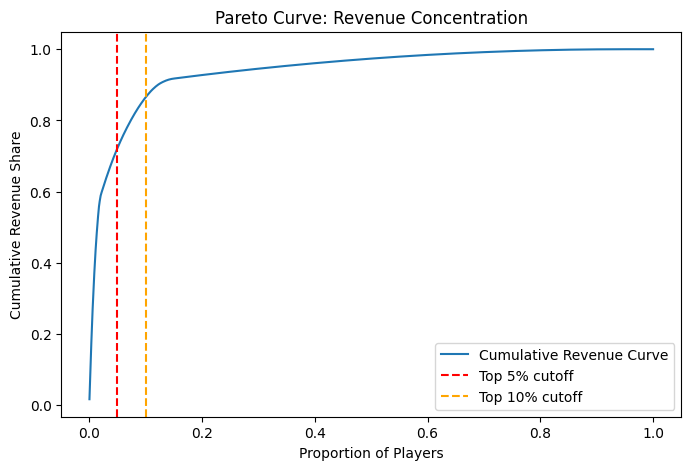

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# =========================
# Step 4.1 Revenue contribution by tier
# =========================
# sum of player segmentation
revenue_by_tier = df.groupby("tier")["spend"].sum().sort_values(ascending=False)
revenue_share = revenue_by_tier / revenue_by_tier.sum()

print("\nRevenue contribution by tier:")
print(revenue_by_tier)
print("\nRevenue share by tier:")
print(revenue_share)

revenue_share.plot(kind="bar", title="Revenue Share by Player Tier")
plt.ylabel("Share of Total Revenue")
plt.show()

# =========================
# Step 4.2 Pareto Analysis (Top X% players)
# =========================
# descreading rank
df_sorted = df.sort_values(by="spend", ascending=False).reset_index(drop=True)

# accumulate the gold
df_sorted["cum_revenue"] = df_sorted["spend"].cumsum()
df_sorted["cum_pct_revenue"] = df_sorted["cum_revenue"] / df_sorted["spend"].sum()

df_sorted["player_pct"] = (np.arange(len(df_sorted)) + 1) / len(df_sorted)

top_5_pct_cutoff = int(0.05 * len(df_sorted))
top_10_pct_cutoff = int(0.10 * len(df_sorted))

top_5_pct_revenue = df_sorted.iloc[:top_5_pct_cutoff]["spend"].sum()
top_10_pct_revenue = df_sorted.iloc[:top_10_pct_cutoff]["spend"].sum()
total_revenue = df_sorted["spend"].sum()

print(f"\nTop 5% players contribute: {top_5_pct_revenue/total_revenue:.2%} of total revenue")
print(f"Top 10% players contribute: {top_10_pct_revenue/total_revenue:.2%} of total revenue")

# 绘制帕累托曲线
plt.figure(figsize=(8,5))
plt.plot(df_sorted["player_pct"], df_sorted["cum_pct_revenue"], label="Cumulative Revenue Curve")
plt.axvline(0.05, color="red", linestyle="--", label="Top 5% cutoff")
plt.axvline(0.10, color="orange", linestyle="--", label="Top 10% cutoff")
plt.title("Pareto Curve: Revenue Concentration")
plt.xlabel("Proportion of Players")
plt.ylabel("Cumulative Revenue Share")
plt.legend()
plt.show()



[Sanity] Tier distribution by group (should be similar):
group            A         B
tier                        
nonpayer  0.045033  0.045575
minnow    0.200000  0.200132
dolphin   0.615232  0.614267
whale     0.139735  0.140026

A/B Metrics
Control (A): {'n': 1510, 'payers': np.int64(1442), 'CR': np.float64(0.9549668874172186), 'ARPU': np.float64(85.02462251655629), 'ARPPU': np.float64(89.03410540915395), 'Median': np.float64(11.64), 'P95': np.float64(368.9119999999998)}
Treatment (B): {'n': 1514, 'payers': np.int64(1449), 'CR': np.float64(0.9570673712021136), 'ARPU': np.float64(116.43271895640686), 'ARPPU': np.float64(121.65571877156661), 'Median': np.float64(11.865000000000002), 'P95': np.float64(378.4247249999994)}

Welch t-test on ARPU: t=1.8831, p=0.05979
Mann–Whitney U on distributions: U=1173956, p=0.1982
Two-proportion z-test on CR: z=0.282, p=0.7782

Bootstrap ARPU diff (B - A): mean=31.37, 95% CI=(-2.02, 64.76)
Observed ARPU lift: 36.94%


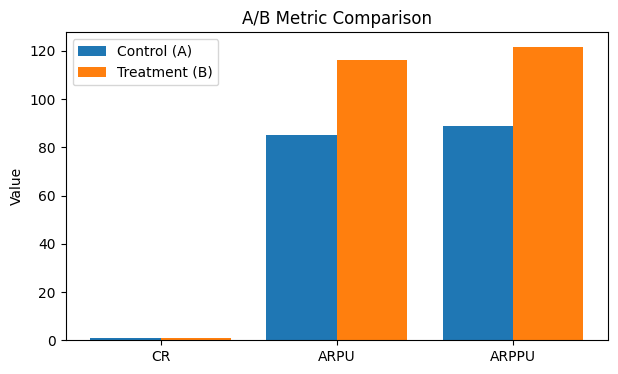

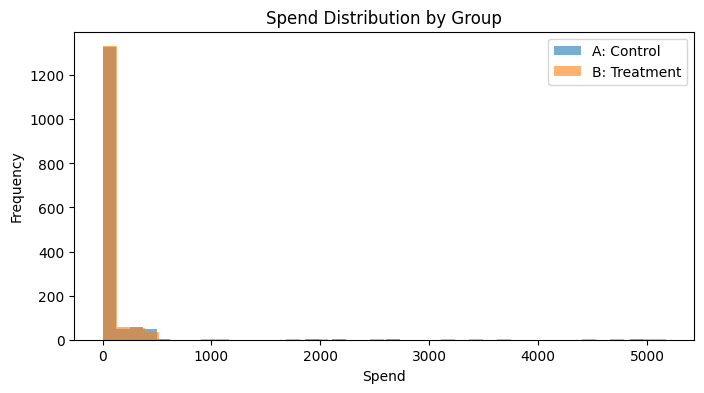

In [16]:
# =========================
# STEP 5 — A/B test simulation (pricing / bundle experiment)
# =========================
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu, norm
import matplotlib.pyplot as plt

np.random.seed(42)

# --- 5.1 Split players into groups with tier stratification ---
# Keep tier proportions similar in each group to reduce variance.
df_ab = df.copy()
df_ab["group"] = None

for tier_name, sub in df_ab.groupby("tier", observed=True):
    # random split within each tier
    idx = sub.index.values
    np.random.shuffle(idx)
    half = len(idx) // 2
    df_ab.loc[idx[:half], "group"] = "A"
    df_ab.loc[idx[half:], "group"] = "B"

# Sanity check: tier distribution per group
tier_dist_ab = pd.crosstab(df_ab["tier"], df_ab["group"], normalize="columns")
print("\n[Sanity] Tier distribution by group (should be similar):")
print(tier_dist_ab)

# --- 5.2 Define experiment knobs (business assumptions) ---
# aov_uplift: multiplicative lift for existing payers' spend in treatment
# nonpayer_conv_rate: fraction of nonpayers converted to payers in treatment
aov_uplift = 0.05            # +5% AOV (pricing/bundle perceived value)
nonpayer_conv_rate = 0.05    # convert 5% of nonpayers

# --- 5.3 Build control and treatment outcomes ---
# Control outcome = current observed "spend"
df_ab["spend_ctrl"] = df_ab["spend"].astype(float)

# Treatment outcome:
#  (1) For existing payers: multiply spend by (1 + aov_uplift)
#  (2) For nonpayers: convert a fraction to first-time buyers; sample amount from minnows' spend distribution
df_ab["spend_treat"] = df_ab["spend_ctrl"].copy()

# (1) uplift for existing payers
payer_mask = df_ab["spend_ctrl"] > 0
df_ab.loc[payer_mask & (df_ab["group"] == "B"), "spend_treat"] *= (1.0 + aov_uplift)

# (2) convert a share of nonpayers in treatment group
nonpayer_mask = (df_ab["spend_ctrl"] == 0) & (df_ab["group"] == "B")

# build empirical distribution for minnow first-purchase amounts
minnow_dist = df_ab.loc[df_ab["tier"] == "minnow", "spend_ctrl"]
# fallback guard if there are too few minnows
if len(minnow_dist) < 10:
    # use a small positive Gamma-like synthetic distribution as fallback
    minnow_dist = pd.Series(np.random.gamma(shape=1.5, scale=3.0, size=1000))

to_convert = nonpayer_mask & (np.random.rand(len(df_ab)) < nonpayer_conv_rate)
n_convert = to_convert.sum()

if n_convert > 0:
    sampled_first_purchases = np.random.choice(minnow_dist.values, size=n_convert, replace=True)
    df_ab.loc[to_convert, "spend_treat"] = sampled_first_purchases

# --- 5.4 Compute metrics per group (Control uses group==A & spend_ctrl; Treatment uses group==B & spend_treat) ---
def summarize_metrics(spend_series: pd.Series) -> dict:
    spend = spend_series.fillna(0.0).astype(float)
    n = len(spend)
    pay = (spend > 0).sum()
    cr = pay / n  # conversion rate
    arpu = spend.mean()
    arppu = spend[spend > 0].mean() if pay > 0 else 0.0
    med = np.median(spend)
    p95 = np.percentile(spend, 95)
    return {
        "n": n,
        "payers": pay,
        "CR": cr,
        "ARPU": arpu,
        "ARPPU": arppu,
        "Median": med,
        "P95": p95,
    }

ctrl = summarize_metrics(df_ab.loc[df_ab["group"] == "A", "spend_ctrl"])
treat = summarize_metrics(df_ab.loc[df_ab["group"] == "B", "spend_treat"])

print("\nA/B Metrics")
print("Control (A):", ctrl)
print("Treatment (B):", treat)

# --- 5.5 Frequentist tests ---
#  a) Mean ARPU difference (Welch's t-test)
ctrl_arpu = df_ab.loc[df_ab["group"] == "A", "spend_ctrl"].fillna(0.0).astype(float)
treat_arpu = df_ab.loc[df_ab["group"] == "B", "spend_treat"].fillna(0.0).astype(float)
t_stat, p_val = ttest_ind(treat_arpu, ctrl_arpu, equal_var=False)
print(f"\nWelch t-test on ARPU: t={t_stat:.4f}, p={p_val:.4g}")

#  b) Median (non-parametric) — Mann-Whitney U
u_stat, p_val_u = mannwhitneyu(treat_arpu, ctrl_arpu, alternative="two-sided")
print(f"Mann–Whitney U on distributions: U={u_stat:.0f}, p={p_val_u:.4g}")

#  c) Conversion rate difference — two-proportion z-test
def two_prop_z_test(success_a, total_a, success_b, total_b):
    # pooled proportion
    p_pool = (success_a + success_b) / (total_a + total_b)
    se = np.sqrt(p_pool * (1 - p_pool) * (1/total_a + 1/total_b))
    z = ((success_b/total_b) - (success_a/total_a)) / se
    p = 2 * (1 - norm.cdf(abs(z)))
    return z, p

z_cr, p_cr = two_prop_z_test(
    success_a=ctrl["payers"], total_a=ctrl["n"],
    success_b=treat["payers"], total_b=treat["n"]
)
print(f"Two-proportion z-test on CR: z={z_cr:.3f}, p={p_cr:.4g}")

# --- 5.6 Bootstrap CI for ARPU lift ---
def bootstrap_diff_ci(a: np.ndarray, b: np.ndarray, n_boot=5000, alpha=0.05, rng=None):
    if rng is None:
        rng = np.random.default_rng(123)
    diffs = np.empty(n_boot, dtype=float)
    n_a, n_b = len(a), len(b)
    for i in range(n_boot):
        samp_a = a[rng.integers(0, n_a, n_a)]
        samp_b = b[rng.integers(0, n_b, n_b)]
        diffs[i] = samp_b.mean() - samp_a.mean()
    lo = np.quantile(diffs, alpha/2)
    hi = np.quantile(diffs, 1 - alpha/2)
    return diffs.mean(), (lo, hi)

mean_diff, (ci_lo, ci_hi) = bootstrap_diff_ci(ctrl_arpu.values, treat_arpu.values, n_boot=5000, alpha=0.05)
lift_pct = (treat["ARPU"] / ctrl["ARPU"] - 1.0) if ctrl["ARPU"] > 0 else np.nan
print(f"\nBootstrap ARPU diff (B - A): mean={mean_diff:.2f}, 95% CI=({ci_lo:.2f}, {ci_hi:.2f})")
print(f"Observed ARPU lift: {lift_pct*100:.2f}%")

# --- 5.7 Simple visuals ---
# Lift bar chart
metrics = ["CR", "ARPU", "ARPPU"]
ctrl_vals = [ctrl[m] for m in metrics]
treat_vals = [treat[m] for m in metrics]
x = np.arange(len(metrics))

plt.figure(figsize=(7,4))
plt.bar(x-0.2, ctrl_vals, width=0.4, label="Control (A)")
plt.bar(x+0.2, treat_vals, width=0.4, label="Treatment (B)")
plt.xticks(x, metrics)
plt.title("A/B Metric Comparison")
plt.ylabel("Value")
plt.legend()
plt.show()

# Spend distribution (optional)
plt.figure(figsize=(8,4))
plt.hist(ctrl_arpu, bins=40, alpha=0.6, label="A: Control")
plt.hist(treat_arpu, bins=40, alpha=0.6, label="B: Treatment")
plt.title("Spend Distribution by Group")
plt.xlabel("Spend")
plt.ylabel("Frequency")
plt.legend()
plt.show()


             players  payers   revenue        ARPU       ARPPU
CohortMonth                                                   
2025-01          379     378  34900.30   92.085224   92.328836
2025-02          346     346  33392.30   96.509538   96.509538
2025-03          396     396  38898.62   98.228838   98.228838
2025-04          386     386  50933.49  131.952047  131.952047
2025-05          418     418  36624.11   87.617488   87.617488
2025-06          372     372  38603.64  103.773226  103.773226
2025-07          416     416  47521.38  114.234087  114.234087
2025-08          175     175  15385.47   87.916971   87.916971


<Axes: title={'center': 'ARPU by Cohort Month'}, xlabel='CohortMonth'>

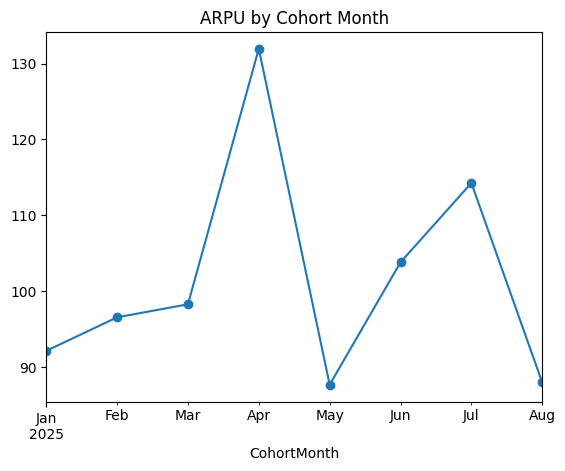

In [17]:
# =========================
# STEP 6 — cohorts analysis
# =========================
# Convert LastPurchaseDate to datetime
df["LastPurchaseDate"] = pd.to_datetime(df["LastPurchaseDate"], errors="coerce")

# Create cohort by month of first purchase
df["CohortMonth"] = pd.to_datetime(df["LastPurchaseDate"]).dt.to_period("M")

# Group by cohort and calculate metrics
cohort_metrics = df.groupby("CohortMonth").agg(
    players=("UserID", "nunique"),
    payers=("is_payer", "sum"),
    revenue=("spend", "sum")
)
cohort_metrics["ARPU"] = cohort_metrics["revenue"] / cohort_metrics["players"]
cohort_metrics["ARPPU"] = cohort_metrics["revenue"] / cohort_metrics["payers"]

print(cohort_metrics)

# Plot ARPU trend across cohorts
cohort_metrics["ARPU"].plot(kind="line", marker="o", title="ARPU by Cohort Month")


                users  conversion
Active           3024    1.000000
First Purchase   2887    0.954696
Dolphin+         2282    0.754630
Whale             423    0.139881


<Axes: title={'center': 'Funnel Conversion Rates'}>

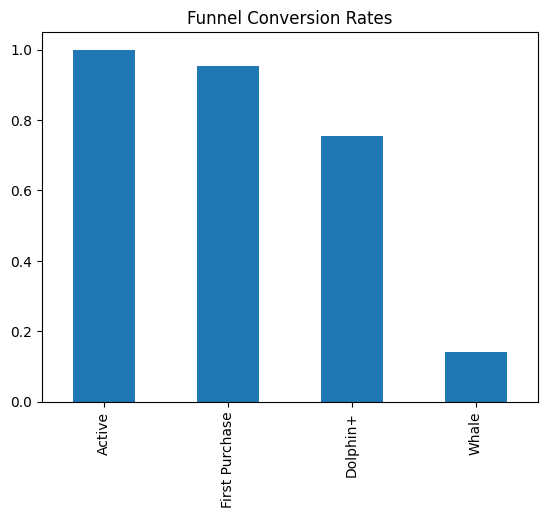

In [19]:
# =========================
# STEP 7 — funnel analysis
# =========================

funnel = {
    "Active": (df["SessionCount"] > 0).sum(),
    "First Purchase": (df["spend"] > 0).sum(),
    "Dolphin+": df["tier"].isin(["dolphin", "whale"]).sum(),
    "Whale": (df["tier"] == "whale").sum()
}

funnel_df = pd.DataFrame.from_dict(funnel, orient="index", columns=["users"])
funnel_df["conversion"] = funnel_df["users"] / funnel_df.iloc[0,0]
print(funnel_df)

# Visualize funnel
funnel_df["conversion"].plot(kind="bar", title="Funnel Conversion Rates")


FirstPurchaseDaysAfterInstall
0.0       45.222100
1.0       86.177914
2.0      219.069141
3.0      261.071666
4.0      363.539597
5.0      413.992313
6.0      581.698655
7.0      630.906030
8.0      734.560598
9.0      859.950098
10.0     946.329800
11.0    1220.700433
12.0    1305.275139
13.0    1370.837777
14.0    1529.371803
15.0    1643.963726
16.0    1689.852021
17.0    1730.671132
18.0    1767.247524
19.0    1892.677139
20.0    1936.845216
21.0    2037.795109
22.0    2214.410005
23.0    2344.107889
24.0    2552.299928
25.0    2669.572043
26.0    2712.070723
27.0    2755.690625
28.0    2968.522198
29.0    3050.643753
30.0    3130.096878
Name: spend, dtype: float64


<Axes: title={'center': 'LTV Curve (Cumulative Revenue by Days After Install)'}, xlabel='FirstPurchaseDaysAfterInstall'>

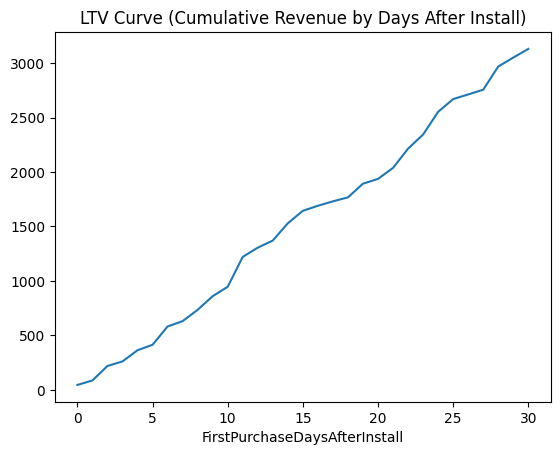

In [20]:
# =========================
# STEP 7 — LTV curve
# =========================df["FirstPurchaseDaysAfterInstall"] = pd.to_numeric(
df["FirstPurchaseDaysAfterInstall"] = pd.to_numeric(
    df["FirstPurchaseDaysAfterInstall"], errors="coerce"
).fillna(0)

ltv_curve = df.groupby("FirstPurchaseDaysAfterInstall")["spend"].mean().cumsum()
print(ltv_curve)

ltv_curve.plot(title="LTV Curve (Cumulative Revenue by Days After Install)")
